In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pickle

In [ ]:
# Загрузка DataFrame из файла
with open(r'./datasets/seg_maps_dataset.pkl', 'rb') as f:
    maps = pickle.load(f)

In [ ]:
# Загрузка DataFrame из файла
with open(r'./datasets/dataset.pkl', 'rb') as f:
    df = pickle.load(f)

crystal = df['Crystal']
Crystal = []

for i in crystal:
    i = i[1:]
    foo, fooo = i.split(".")
    i = foo
    #print(i)
    Crystal.append(i)

df['Crystal'] = Crystal
df = df.loc[((df['Crystal'] != 'Ag') & (df['Crystal'] != 'Au') & (df['Crystal'] != 'B4C'))]
df = df.reset_index()
df

,index,Matrix,Crystal,Stats,Pulce duration
0,120,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",Al,10000000.0,10.000000
1,121,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",Al,10000000.0,25.263158
2,122,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",Al,10000000.0,40.526316
3,123,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",Al,10000000.0,55.789474
4,124,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",Al,10000000.0,71.052632
...,...,...,...,...,...
4195,4555,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",Y2O3,500000000.0,238.947368
4196,4556,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",Y2O3,500000000.0,254.210526
4197,4557,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",Y2O3,500000000.0,269.473684
4198,4558,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",Y2O3,500000000.0,284.736842


In [4]:
df['Crystal'].unique()

array(['Al', 'Al2O3_sapphire', 'Ba', 'Be', 'BeO', 'C_diamond',
       'C_graphite', 'Cr', 'Cs', 'Cu', 'Cu2MnAl', 'Fe', 'Ga', 'Gd', 'Ge',
       'H2O_ice_1h', 'He4_hcp', 'Hg', 'I2', 'K', 'Li', 'LiF', 'Mo',
       'Na2Ca3Al2F14', 'Nb', 'Ni', 'Pb', 'Pt', 'Rb', 'Si', 'Ti', 'Tl',
       'UO2', 'Zn', 'Y2O3'], dtype=object)

In [15]:
import numpy as np

def threshold_matrix(matrix, k):
    """
    Зануляет пиксели, меньшие max_value * k, остальные делает равными 1.

    Параметры:
        matrix (numpy.ndarray): Входная матрица (2D или 3D).
        max_value (float): Максимальное значение для порога.
        k (float): Коэффициент порога (0 < k < 1).

    Возвращает:
        numpy.ndarray: Матрица с 0 и 1.
    """

    # Примерные координаты углов трапеции
    x1, y1 = 238, 21   # Верхний левый
    x2, y2 = 243, 21   # Верхний правый
    x3, y3 = 224, 240  # Нижний левый
    x4, y4 = 256, 240  # Нижний правый

    max_value = np.max(matrix)
    threshold = max_value * k
    binary_matrix = np.where(matrix >= threshold, 1, 0)

    for y in range(y1, y3+1):
        left_x = int(x1 + (x3 - x1) * (y - y1) / (y3 - y1))
        right_x = int(x2 + (x4 - x2) * (y - y2) / (y4 - y2))
        binary_matrix[y, left_x:right_x] = 0  # Используем y как индекс строки, а x как индекс столбца

    return binary_matrix

def argmax_with_p_value(matrix, p_value):
    """
    Зануляет пиксели, меньшие max_value * k, остальные делает равными 1.

    Параметры:
        matrix (numpy.ndarray): Входная матрица (2D или 3D).
        max_value (float): Максимальное значение для порога.
        k (float): Коэффициент порога (0 < k < 1).

    Возвращает:
        numpy.ndarray: Матрица с 0 и 1.
    """
    binary_matrix = np.where(matrix >= p_value, 1, 0)
    return binary_matrix

In [16]:
import numpy as np

def calculate_iou(true_mask, pred_mask):
    """
    Вычисляет IoU (Intersection over Union) между двумя бинарными масками.

    Параметры:
        true_mask (numpy.ndarray): Исходная бинарная маска (0 и 1).
        pred_mask (numpy.ndarray): Предсказанная бинарная маска (0 и 1).

    Возвращает:
        float: Значение IoU в диапазоне [0, 1].
    """
    # Проверка на одинаковую форму
    if true_mask.shape != pred_mask.shape:
        raise ValueError("Маски должны иметь одинаковую форму!")
    
    # Пересечение (логическое И)
    intersection = np.logical_and(true_mask, pred_mask).sum()
    
    # Объединение (логическое ИЛИ)
    union = np.logical_or(true_mask, pred_mask).sum()
    
    # Избегаем деления на 0
    if union == 0:
        return 0.0
    
    iou = intersection / union
    return iou

0.8499959524002266


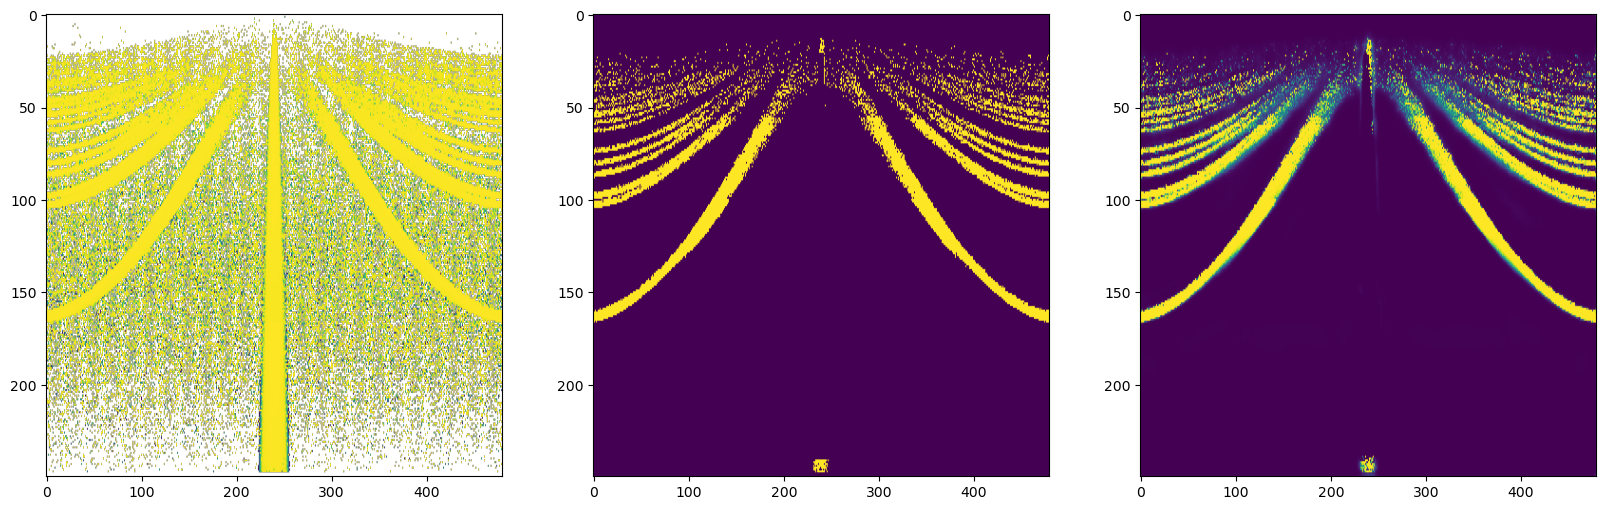

In [59]:
samples = {'Al': 0 , 'Al2O3_sapphire' : 0 , 'C_graphite' : 0 , 'Na2Ca3Al2F14' : 0 , 'Rb' : 0 , 'Si' : 0 , 'UO2' : 0 , 'Y2O3': 0}

maxStats = max(df['Stats'].unique())
maxI = max(df['Pulce duration'].unique())

selected_row = df[
    (df['Crystal'] == 'C_graphite') &
    (df['Stats'] == maxStats) &
    (df['Pulce duration'] == maxI)
]

diffraction = selected_row['Matrix'].values[0]

selected_row = maps[
    (maps['Crystal'] == 'C_graphite') &
    (maps['Stats'] == maxStats) &
    (maps['Pulce duration'] == maxI)
]

segmentation_map = selected_row['Matrix'].values[0]

# Создаем фигуру и оси
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

# Первый график
ax1.imshow(diffraction, cmap='viridis', aspect='auto', norm='log')

k = 0.002

test_mask = threshold_matrix(diffraction, k)

ax2.imshow(test_mask, cmap='viridis', aspect='auto')

ax3.imshow(segmentation_map, cmap='viridis', aspect='auto')

p_value = 0.5

binary_segmentation_map = argmax_with_p_value(segmentation_map, p_value)

IoU = calculate_iou(test_mask, binary_segmentation_map)
print(IoU)

plt.show()

In [54]:
p_values = np.arange(0.01, 1, 0.01)
maxStats = 5.e+08
maxI = max(df['Pulce duration'].unique())
koefs = [0.001, 0.002, 0.001, 0.002, 0.001, 0.001, 0.002, 0.002]


for sample, koef in zip(samples, koefs):
    selected_row = df[
        (df['Crystal'] == sample) &
        (df['Stats'] == maxStats) &
        (df['Pulce duration'] == maxI)
    ]

    diffraction = selected_row['Matrix'].values[0]

    test_mask = threshold_matrix(diffraction, koef)

    selected_row = maps[
        (maps['Crystal'] == sample) &
        (maps['Stats'] == maxStats) &
        (maps['Pulce duration'] == maxI)
    ]

    segmentation_map = selected_row['Matrix'].values[0]

    IoUs = []

    for p_value in p_values:
        
        binary_segmentation_map = argmax_with_p_value(segmentation_map, p_value)
        IoU = calculate_iou(test_mask, binary_segmentation_map)
        IoUs.append(IoU)

    samples[sample] = IoUs

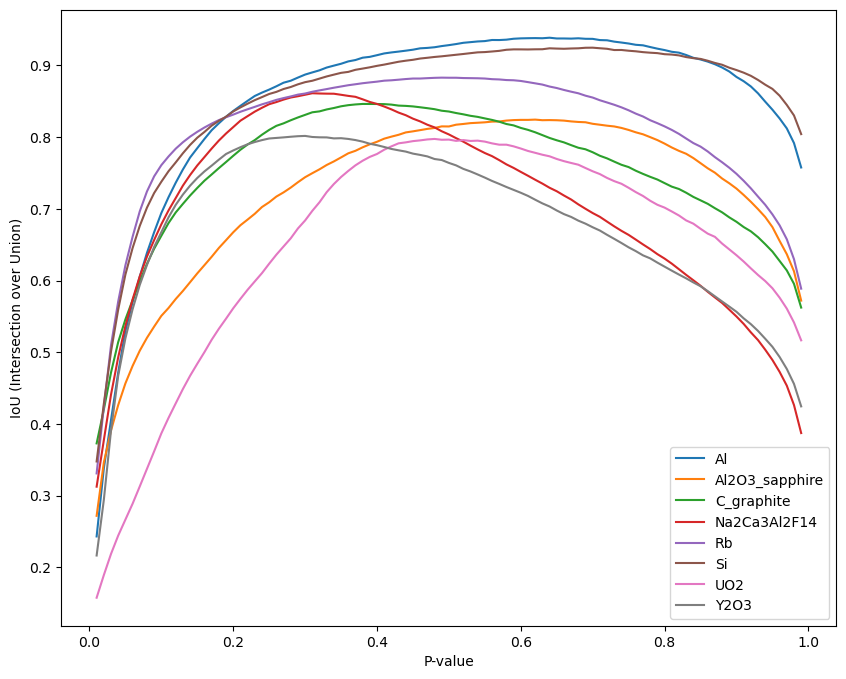

In [55]:
plt.figure(figsize=(10, 8))

for sample in samples:
    plt.plot(p_values, samples[sample], label = sample)

plt.ylabel('IoU (Intersection over Union)')
plt.xlabel('P-value')
plt.legend()
plt.show()